In [ ]:
!pip install lime
!pip install shap
!pip install PyALE
!pip install dalex
!pip install dice_ml
!pip install alibi

In [33]:
#Load the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
#Load the data
df=pd.read_csv("https://raw.githubusercontent.com/joofio/xai-workshop/main/diabetes.csv")

#View the data
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [36]:
#categorical outcome
train,test = train_test_split(df, test_size=0.2, random_state=42,stratify=df["Outcome"])

display(train["Outcome"].value_counts())
display(test["Outcome"].value_counts())
Y = train['Outcome']
X = train.iloc[:,0:-1]
X_test=test.iloc[:,0:-1]

Outcome
0    400
1    214
Name: count, dtype: int64

Outcome
0    100
1     54
Name: count, dtype: int64

In [3]:
mc_clf = RandomForestClassifier().fit(X, Y)


## PDP

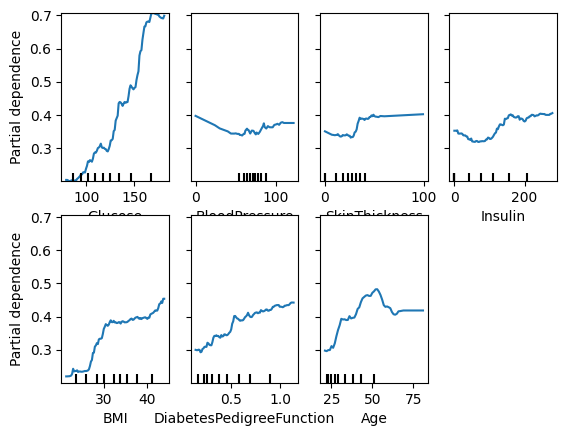

In [4]:
PartialDependenceDisplay.from_estimator(mc_clf, X,[1,2,3,4,5,6,7],n_cols=4);

## ICE


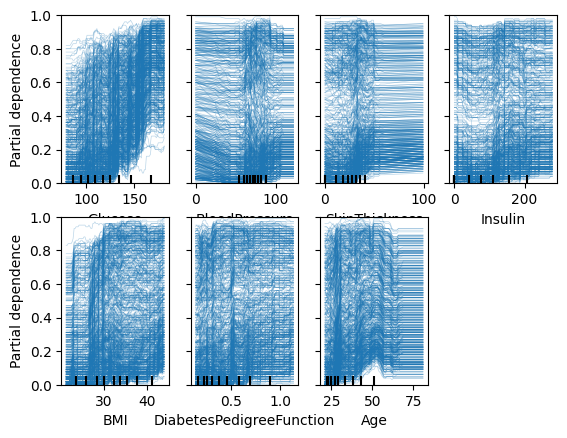

In [5]:
PartialDependenceDisplay.from_estimator(mc_clf, X,[1,2,3,4,5,6,7],n_cols=4,kind="individual");


## Accumulated Local Effects Plots

PyALE._ALE_generic:INFO: Continuous feature detected.


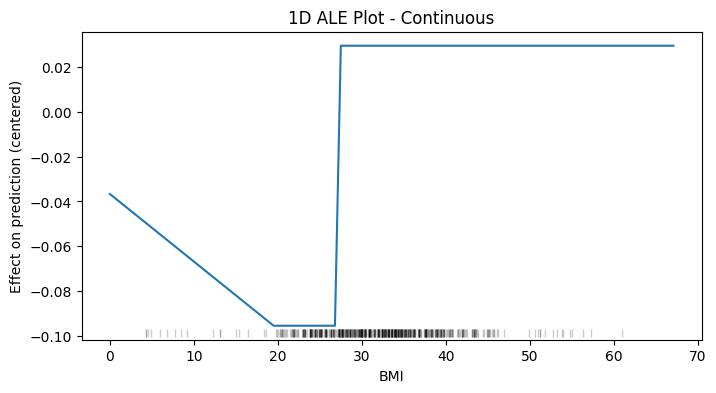

In [6]:
from PyALE import ale


## 1D - continuous - no CI
ale_eff = ale(
    X=X, model=mc_clf, feature=["BMI"], grid_size=40, include_CI=False
)

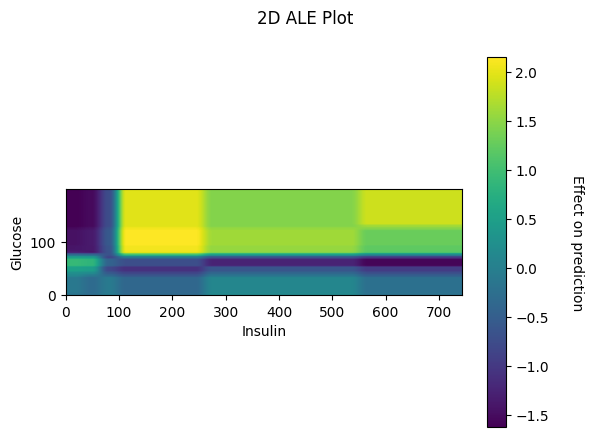

In [7]:

#2D
ale_eff = ale(
    X=X, model=mc_clf, feature=["Glucose","Insulin"], grid_size=40, include_CI=True
)

## Breakdown

In [8]:
import dalex as dx

exp = dx.Explainer(mc_clf, X, Y)


Preparation of a new explainer is initiated

  -> data              : 614 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 614 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x15d662440> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.35, max = 0.99
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.38, mean = -0.0014, max = 0.4
  -> model_info        : package sklearn

A new explainer has been created!


/opt/homebrew/Caskroom/miniforge/base/envs/xai/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [9]:
my_sample=pd.DataFrame(test.iloc[0,:-1]).T

In [10]:
exp.predict(my_sample)


array([0.72])

In [11]:
bd_mysample = exp.predict_parts(my_sample, type='break_down', label="mysample")
bd_interactions_mysample = exp.predict_parts(my_sample, type='break_down_interactions', label="mysample+")


In [12]:
bd_mysample.result


,variable_name,variable_value,variable,cumulative,contribution,sign,position,label
0,intercept,,intercept,0.349935,0.349935,1.0,9,mysample
1,Glucose,159.0,Glucose = 159.0,0.638290,0.288355,1.0,8,mysample
2,Age,40.0,Age = 40.0,0.680081,0.041792,1.0,7,mysample
3,Pregnancies,7.0,Pregnancies = 7.0,0.754186,0.074104,1.0,6,mysample
4,BloodPressure,64.0,BloodPressure = 64.0,0.755896,0.001710,1.0,5,mysample
5,Insulin,0.0,Insulin = 0.0,0.770912,0.015016,1.0,4,mysample
6,SkinThickness,0.0,SkinThickness = 0.0,0.779349,0.008436,1.0,3,mysample
7,DiabetesPedigreeFunction,0.294,DiabetesPedigreeFunction = 0.294,0.769218,-0.010130,-1.0,2,mysample
8,BMI,27.4,BMI = 27.4,0.720000,-0.049218,-1.0,1,mysample
9,,,prediction,0.720000,0.720000,1.0,0,mysample


In [13]:
bd_mysample.plot(bd_interactions_mysample)


# Feature based

## Permutation Feature Importance

In [14]:
from sklearn.inspection import permutation_importance
r = permutation_importance(mc_clf, X, Y,
                            n_repeats=20,
                            random_state=0)


In [15]:
for idx,i in enumerate(r.importances_mean.argsort()[::-1]):
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[idx]:<8} "
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Pregnancies 0.207 +/- 0.012
Glucose  0.092 +/- 0.010
BloodPressure 0.082 +/- 0.007
SkinThickness 0.065 +/- 0.006
Insulin  0.035 +/- 0.004
BMI      0.027 +/- 0.004
DiabetesPedigreeFunction 0.027 +/- 0.004
Age      0.027 +/- 0.005


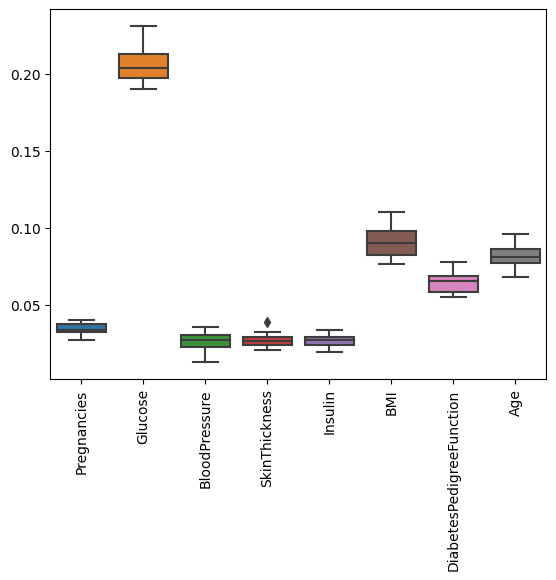

In [16]:
pfi=pd.DataFrame(r["importances"].T)
pfi.columns=X.columns
g=sns.boxplot(pfi);
plt.xticks(rotation=90);


## SHAP

In [18]:
import shap

explainer = shap.TreeExplainer(mc_clf)
shap_values = explainer.shap_values(X)

In [21]:
shap.initjs()

In [22]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X.iloc[0,:])


In [27]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:20,:], X.iloc[:20,:])


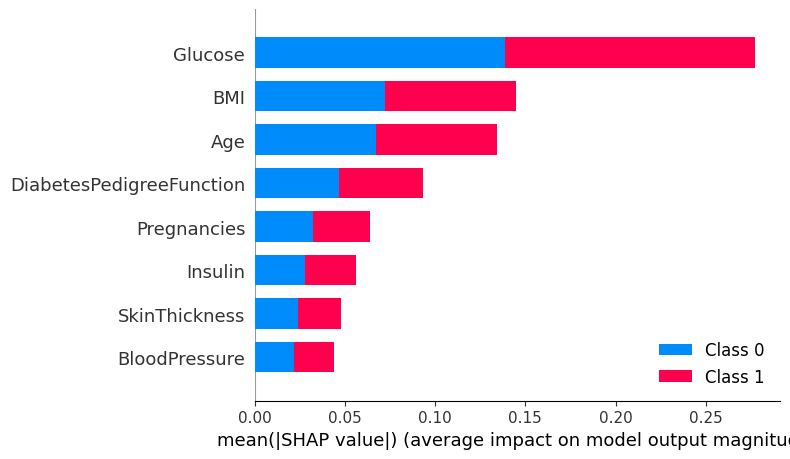

In [28]:
shap.summary_plot(shap_values, X)


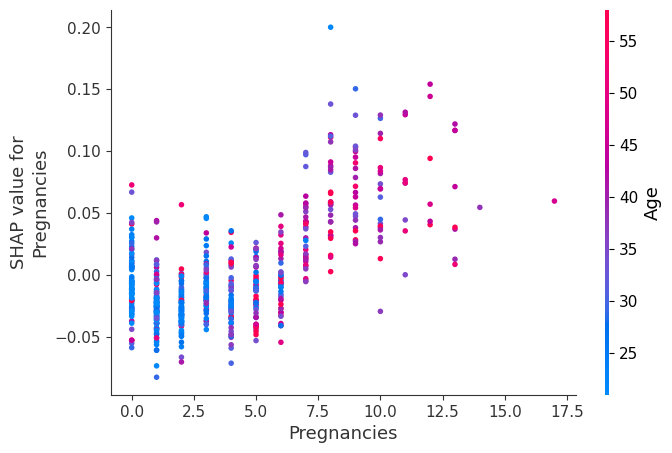

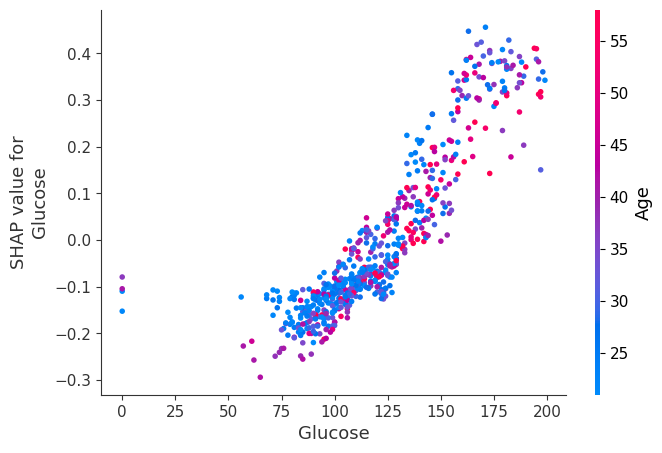

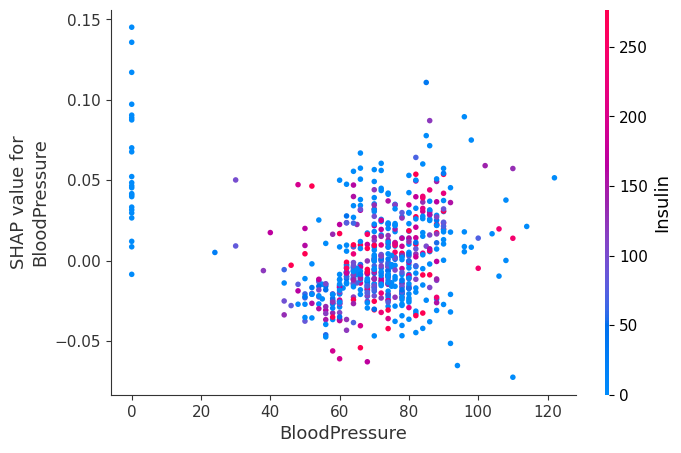

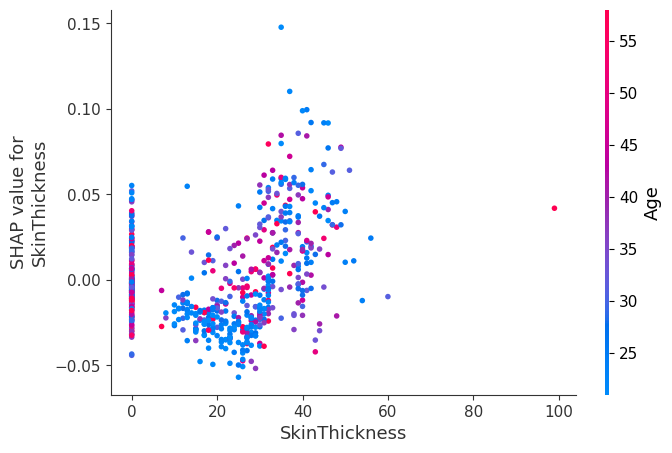

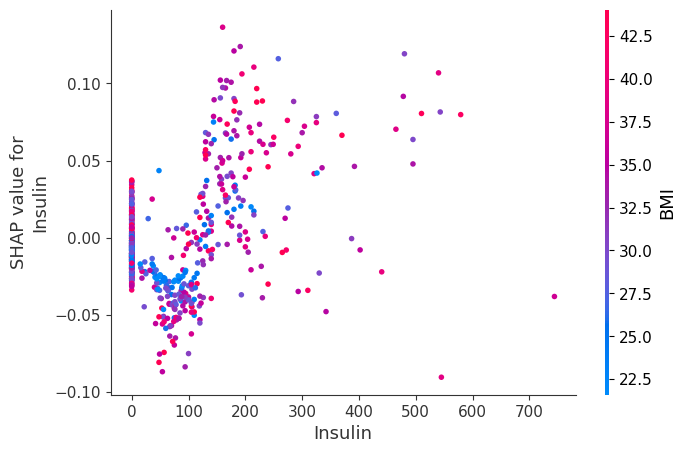

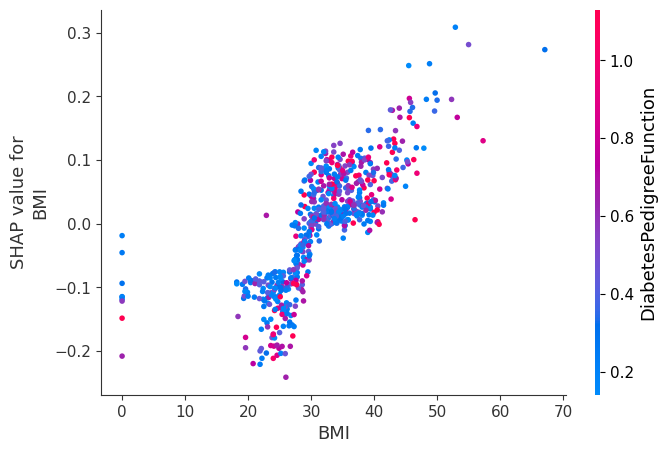

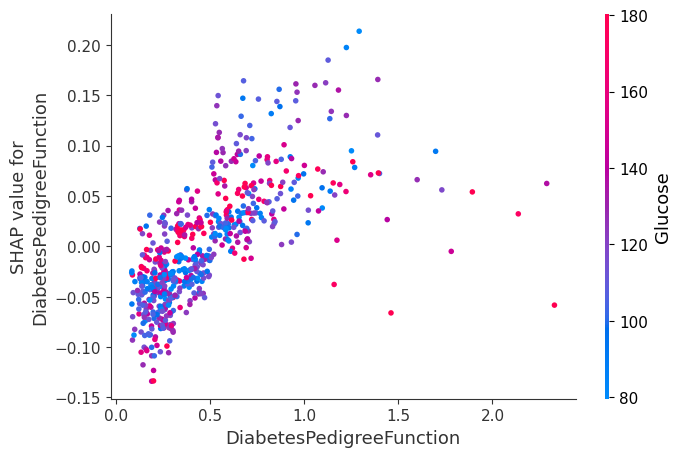

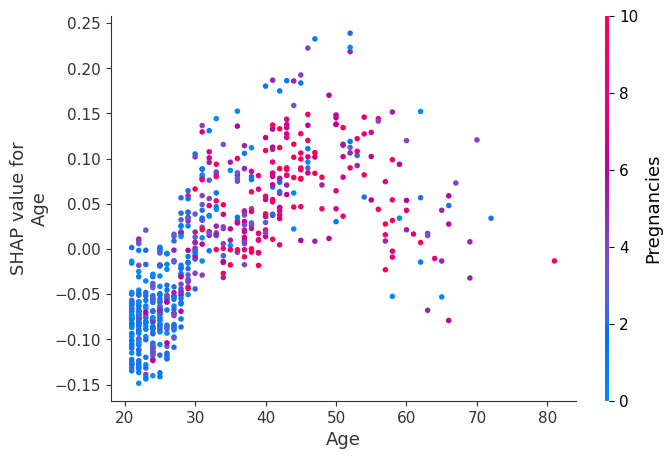

In [29]:
for name in X.columns:
    shap.dependence_plot(name, shap_values[1], X, display_features=X)

## LIME

In [35]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=X.columns,
    class_names=['bad', 'good'],
    mode='classification'
)

In [37]:

exp = explainer.explain_instance(
    data_row=X_test.iloc[1], 
    predict_fn=mc_clf.predict_proba
)

exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


# Example Based

## Trust Scores

In [62]:
from alibi.confidence import TrustScore

ts = TrustScore(k_filter=10,  # nb of neighbors used for kNN distance or probability to filter out outliers
                alpha=.05,  # target fraction of instances to filter out
                filter_type='distance_knn',  # filter method: None, 'distance_knn' or 'probability_knn'
                leaf_size=40,  # affects speed and memory to build KDTrees, memory scales with n_samples / leaf_size
                metric='euclidean',  # distance metric used for the KDTrees
                dist_filter_type='point')  # 'point' uses distance to k-nearest point
                                           # 'mean' uses average distance from the 1st to the kth

In [65]:
y_pred = mc_clf.predict(X_test)


In [75]:
ts.fit(X.values, Y.values, classes=2)


In [77]:
score, closest_class = ts.score(X_test, 
                                y_pred, 
                                k=2,
                                dist_type='point')
print(f'Trust scores: {score}')
print(f'\nClosest not predicted class: {closest_class}')

Trust scores: [1.92984115 1.22385876 1.46312413 1.44885723 2.0928342  1.0565475
 0.81630394 1.56125981 2.88132784 1.44909677 1.43198016 1.97441688
 1.19417563 0.36744794 1.85421808 1.15026637 2.14169197 2.17877165
 1.53746109 3.50476943 1.19980413 1.25264059 1.27739901 1.22840905
 0.92199246 1.77023398 3.08188542 3.39457611 1.65331661 1.99867354
 1.83861649 1.8364667  1.09215563 0.51019774 1.08306027 1.14878145
 0.98854192 1.94368528 1.26967859 1.06742965 0.85880026 1.78483243
 1.02201076 0.695403   1.06140325 0.84815142 2.59826186 2.01278405
 2.03109455 0.53800275 0.95518693 2.68231899 1.10009222 1.99695254
 0.80541623 1.71143278 0.95187516 1.62814699 2.03693015 0.81450926
 1.47749179 1.48057119 2.57236537 2.23910491 2.19979098 0.56434583
 1.57245616 2.15925254 1.00663443 0.95437805 1.85998532 2.41317988
 1.32359366 0.98872167 2.01368923 1.07634841 2.30342241 0.67506769
 2.31012287 2.42292739 1.66831886 1.19517939 2.47339956 1.14991044
 1.82343442 2.21847776 0.99450949 0.46717519 2.19

In [93]:
y_pred_1=mc_clf.predict_proba(X_test)[:,1]

In [108]:
data=pd.concat((pd.DataFrame(y_pred_1),pd.DataFrame(score)),axis=1)
data.columns=["pred","score"]

In [110]:
data

,pred,score
0,0.72,1.929841
1,0.21,1.223859
2,0.07,1.463124
3,0.33,1.448857
4,0.04,2.092834
...,...,...
149,0.01,3.268135
150,0.06,1.652205
151,0.11,1.858542
152,0.76,3.111793


<Axes: ylabel='pred'>

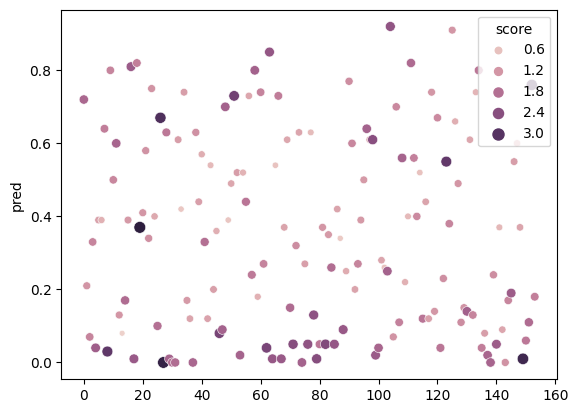

In [114]:
sns.scatterplot(x=data.index,y=data["pred"],size=data["score"],hue=data["score"])

## Counterfactuals

In [54]:
# import DiCE
import dice_ml
from dice_ml.utils import helpers  # helper functions
# provide the trained ML model to DiCE's model object
d = dice_ml.Data(dataframe=df, continuous_features=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'], outcome_name='Outcome')

backend = 'sklearn'
m = dice_ml.Model(model=mc_clf, backend=backend)

In [55]:
exp_random = dice_ml.Dice(d, m, method="random")


In [56]:
query_instances = X[4:6]
dice_exp_random = exp_random.generate_counterfactuals(query_instances, total_CFs=2, desired_class="opposite", verbose=False)


100%|██████████| 2/2 [00:00<00:00, 15.52it/s]


In [57]:
dice_exp_random.visualize_as_dataframe(show_only_changes=True)


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,95,64,39,105,44.599998,0.366,22,0



Diverse Counterfactual set (new outcome: 1.0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,180.0,-,-,365.0,44.6,0.366,-,1.0
1,-,151.0,-,-,-,44.6,0.366,-,1.0


Query instance (original outcome : 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,5,189,64,33,325,31.200001,0.583,29,1



Diverse Counterfactual set (new outcome: 0.0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,25.0,-,76.0,-,31.2,0.583,-,0.0
1,-,18.0,-,-,-,31.2,0.583,77.0,0.0


In [58]:
# generate counterfactuals
# default random seed is 17
dice_exp_random = exp_random.generate_counterfactuals(query_instances,
                                                      total_CFs=4,
                                                      desired_class="opposite",
                                                      random_seed=9)

100%|██████████| 2/2 [00:00<00:00, 13.87it/s]


In [59]:
dice_exp_random.visualize_as_dataframe(show_only_changes=True)


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,95,64,39,105,44.599998,0.366,22,0



Diverse Counterfactual set (new outcome: 1.0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,-,-,-,548.0,44.6,0.366,47.0,1.0
1,-,196.0,-,-,-,44.6,0.366,-,1.0
2,-,198.0,-,-,-,44.6,0.366,-,1.0
3,15.0,-,-,-,-,44.6,1.777,-,1.0


Query instance (original outcome : 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,5,189,64,33,325,31.200001,0.583,29,1



Diverse Counterfactual set (new outcome: 0.0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,35.0,-,-,-,31.2,0.583,-,0.0
1,-,73.0,-,-,-,39.0,0.583,-,0.0
2,-,103.0,3.0,-,-,31.2,0.583,-,0.0
3,-,53.0,-,-,-,31.2,0.583,-,0.0


In [60]:
# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(
        query_instances, total_CFs=4, desired_class="opposite",
        features_to_vary=['Glucose', 'SkinThickness', 'Insulin', 'BMI'])

100%|██████████| 2/2 [00:00<00:00, 13.57it/s]


In [61]:
dice_exp_random.visualize_as_dataframe(show_only_changes=True)


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,95,64,39,105,44.599998,0.366,22,0



Diverse Counterfactual set (new outcome: 1.0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,180.0,-,-,580.0,44.6,0.366,-,1.0
1,-,150.0,-,-,-,44.6,0.366,-,1.0
2,-,148.0,-,-,405.0,44.6,0.366,-,1.0
3,-,155.0,-,-,-,32.0,0.366,-,1.0


Query instance (original outcome : 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,5,189,64,33,325,31.200001,0.583,29,1



Diverse Counterfactual set (new outcome: 0.0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,9.0,-,51.0,-,31.2,0.583,-,0.0
1,-,67.0,-,-,-,48.5,0.583,-,0.0
2,-,31.0,-,5.0,-,31.2,0.583,-,0.0
3,-,7.0,-,6.0,-,31.2,0.583,-,0.0
